In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

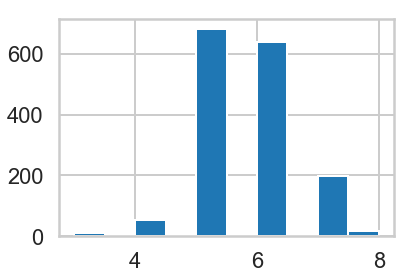

In [4]:
print (df.shape)

plt.hist(df.quality)

In [5]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

c:\users\mohath\practicum\venvr\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [6]:
Xnames = list(df.columns.values[1:11])

In [7]:
np.mean(df['target'])

0.1357098186366479

In [8]:

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
# make sure we didn't get unlucky in our mask selection
print ("% Good wines in Training:", np.mean(df.target[mask]))
print ("% Good wines in Testing:", np.mean(df.target[~mask]))

% Good wines in Training: 0.1386861313868613
% Good wines in Testing: 0.13125


In [10]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 5, 'min_samples_leaf': 2} 0.41801274174009295 {'mean_fit_time': array([0.00099988, 0.00059848, 0.00079956, 0.00079684, 0.00059419,
       0.00079761, 0.00099735, 0.00059581, 0.00099654, 0.00098858,
       0.00099602, 0.0008007 , 0.0007978 , 0.00099721, 0.00039897,
       0.00059838, 0.00059829, 0.00099711, 0.00059834, 0.00099487,
       0.00079756, 0.00079818, 0.00119681, 0.00119672, 0.00099759,
       0.00119686, 0.0007978 , 0.00099707, 0.00099754, 0.00099745,
       0.00099773, 0.00139627, 0.00159335, 0.00139589, 0.00139856,
       0.00119662, 0.0015954 , 0.00139298, 0.00139632, 0.00119638,
       0.00119662, 0.00139675]), 'std_fit_time': array([8.93566605e-04, 4.88658067e-04, 3.99791279e-04, 3.98433539e-04,
       4.85180681e-04, 3.98802853e-04, 7.44843452e-07, 4.86501929e-04,
       3.37646503e-06, 1.23726150e-05, 3.69541107e-06, 4.00367045e-04,
       7.46110812e-04, 3.23406696e-07, 4.88636039e-04, 4.88577656e-04,
       4.88499820e-04, 2.78041453e-07

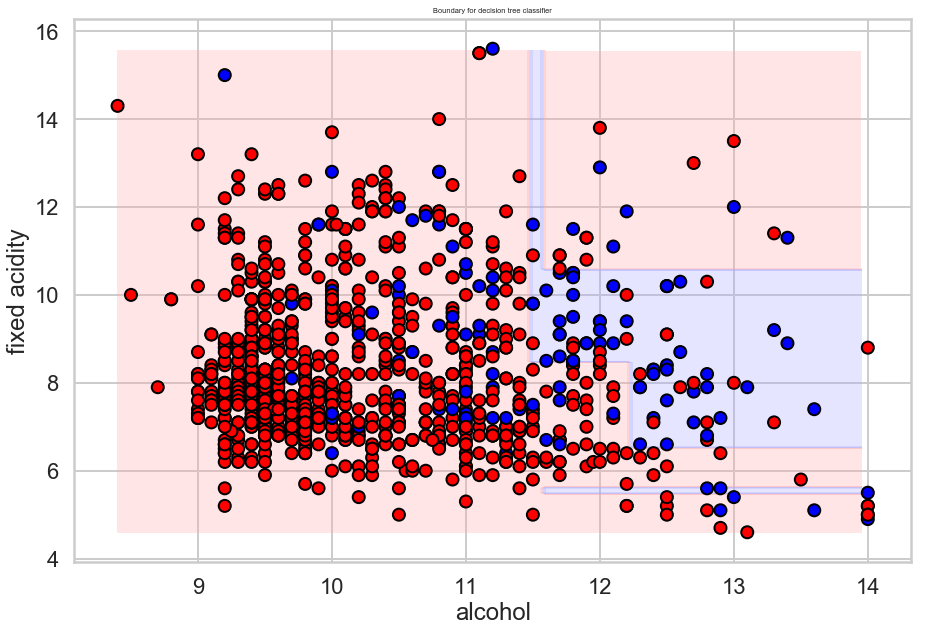

In [11]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

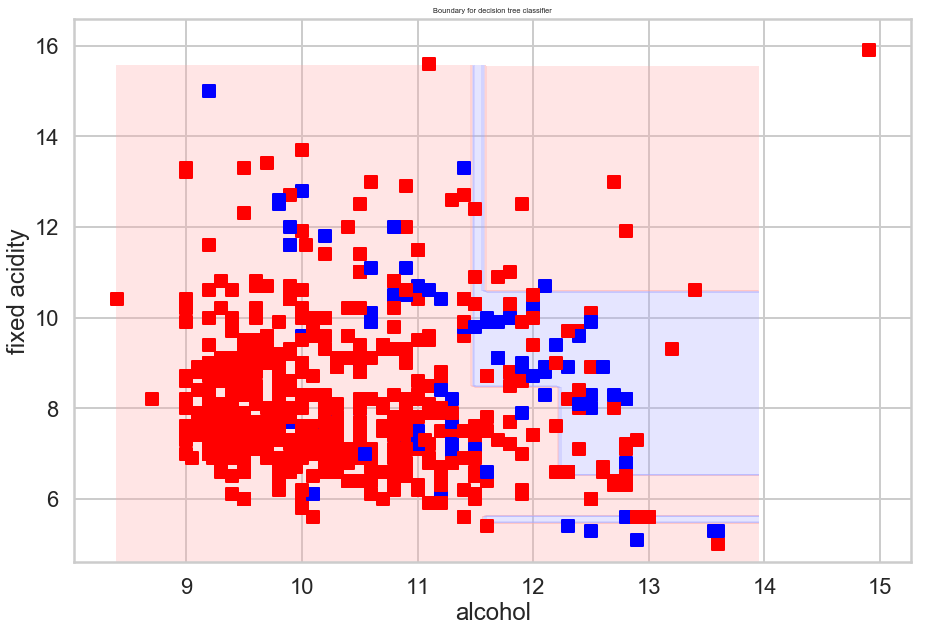

In [12]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

using mask
BEST {'max_depth': None, 'min_samples_leaf': 6} 0.3856354150693773 {'mean_fit_time': array([0.00079803, 0.00099611, 0.00079789]), 'std_fit_time': array([3.99017761e-04, 2.02821215e-05, 3.98945848e-04]), 'mean_score_time': array([0.00121121, 0.00099087, 0.00100398]), 'std_score_time': array([7.52718627e-04, 1.31325143e-05, 1.33531433e-05]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': None, 'min_samples_leaf': 4}, {'max_depth': None, 'min_samples_leaf': 5}, {'max_depth': None, 'min_samples_leaf': 6}], 'split0_test_score': array([0.29411765, 0.24242424, 0.32432432]), 'split1_test_score': array([0.37931034, 0.34666667, 0.43636364]), 'split2_test_score': array([0.43137255, 0.34615385, 0.49056604]), 'split3_tes

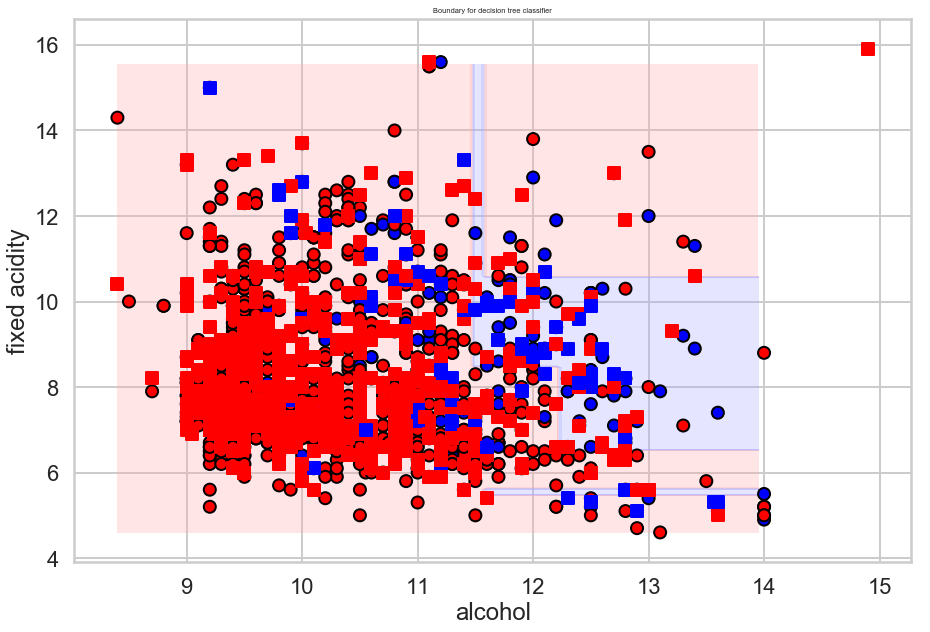

In [13]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

In [14]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 2, 'min_samples_leaf': 1} 0.4797463320992733 {'mean_fit_time': array([0.00099702, 0.00109873, 0.00099678, 0.00159726, 0.00099573,
       0.0009973 , 0.00099802, 0.00139031, 0.00099773, 0.00120482,
       0.00140138, 0.00159187, 0.00199208, 0.00179572, 0.0015954 ,
       0.00179687, 0.00219488, 0.00159426, 0.00199857, 0.00179567,
       0.00219789, 0.00238843, 0.00239339, 0.00239358, 0.0019948 ,
       0.00239344, 0.0025929 , 0.00259333, 0.00199075, 0.00219388,
       0.00298958, 0.00310111, 0.00299211, 0.00318885, 0.00289826,
       0.00319452, 0.00319428, 0.00259223, 0.00338826, 0.00259252,
       0.00419178, 0.00418816, 0.00378904, 0.00359273, 0.0041883 ,
       0.00418897, 0.00378933, 0.00319114, 0.00338707, 0.00319133,
       0.0039887 , 0.00439239, 0.00418482, 0.0039885 , 0.0039897 ,
       0.00398932, 0.00339103, 0.00359154, 0.00398917, 0.00398912,
       0.00438809, 0.00418897, 0.00438304, 0.00458736, 0.0035903 ,
       0.00458775, 0.00458789, 0.003

In [15]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'n_estimators': 18} 0.4602580786483905 {'mean_fit_time': array([0.00378599, 0.00538535, 0.00757947, 0.01056614, 0.01296549,
       0.01535921, 0.01935024, 0.02094374, 0.02413545, 0.02652884,
       0.02812991, 0.03390522, 0.03610172, 0.03949432, 0.04228396,
       0.04348679, 0.04727502, 0.04687271, 0.04872985]), 'std_fit_time': array([0.00039433, 0.00101681, 0.00119643, 0.00185739, 0.00244271,
       0.00365641, 0.00184972, 0.00295902, 0.00146574, 0.00319132,
       0.00262663, 0.00450612, 0.00263154, 0.00205334, 0.00299802,
       0.00376191, 0.0029331 , 0.00670534, 0.00535907]), 'mean_score_time': array([0.00239244, 0.0019948 , 0.00219445, 0.00199475, 0.00219445,
       0.00239515, 0.00338888, 0.00239387, 0.00378981, 0.0035903 ,
       0.00378504, 0.00459189, 0.0051877 , 0.00518899, 0.00459142,
       0.00538254, 0.00478683, 0.00558581, 0.00458736]), 'std_score_time': array([4.88311182e-04, 4.37028474e-07, 9.77466901e-04, 1.05120696e-06,
       7.46085685e-04, 7.971

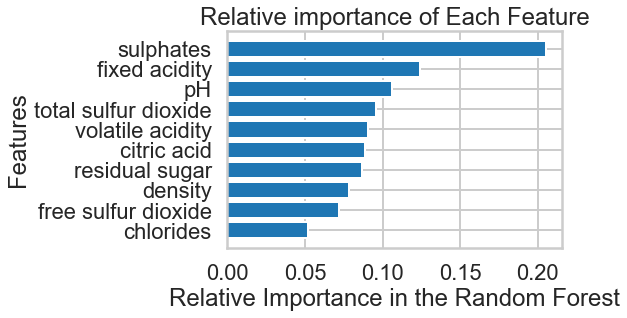

In [16]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'n_estimators': 11} 0.48968734783047385 {'mean_fit_time': array([0.0251246 , 0.02810583, 0.03470783, 0.03849778, 0.03989058,
       0.04348264, 0.0404922 , 0.04827013, 0.04767189, 0.04667516,
       0.04527874, 0.05186138, 0.05166335, 0.05365953, 0.0577219 ,
       0.05923471, 0.06173086, 0.07399893, 0.08041034, 0.08199706,
       0.07970414, 0.07867165, 0.09043293, 0.09109483, 0.09427028,
       0.08860979, 0.09048605, 0.09694061, 0.10354543, 0.10764961,
       0.09374328, 0.0999598 , 0.10215502, 0.10638514, 0.10586462,
       0.10702815, 0.11697822, 0.13784451, 0.12804027, 0.13912168,
       0.1335248 , 0.13002915, 0.13270831, 0.14340396, 0.14712081,
       0.14822745, 0.14900703, 0.15179381, 0.15139756, 0.15031838]), 'std_fit_time': array([0.00291788, 0.00212526, 0.00271168, 0.00162088, 0.00188954,
       0.00635942, 0.00522447, 0.00580124, 0.00324102, 0.001596  ,
       0.00580127, 0.00413616, 0.00400871, 0.00146883, 0.00350901,
       0.00139003, 0.00310193, 0.010

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'max_depth': 4, 'n_estimators': 31} 0.4758456260720411 {'mean_fit_time': array([0.03552008, 0.03630519, 0.03729978, 0.03977728, 0.0413662 ,
       0.04657764, 0.04228921, 0.04657793, 0.0494719 , 0.05335803,
       0.0557487 , 0.05724688, 0.05784492, 0.05604148, 0.05684824,
       0.06163521, 0.06561947, 0.06861653, 0.06502604, 0.0644279 ,
       0.07500043, 0.08828912, 0.08571982, 0.08234229, 0.07715197,
       0.0795001 , 0.08214345, 0.0759903 , 0.08078923, 0.08118272,
       0.05684786, 0.06123629, 0.06402645, 0.07140913, 0.07959189,
       0.07938638, 0.08098302, 0.06941633, 0.06861267, 0.07599754,
       0.08727593, 0.08847098, 0.09076724, 0.07778978, 0.08676906,
       0.08606343, 0.09465384, 0.09810362, 0.10307379, 0.09669347,
       0.11090746, 0.10755286, 0.10721736, 0.1078413 , 0.12091398,
       0.115168  , 0.1202692 , 0.1236342 , 0.12457247, 0.12663794,
       0.09593306, 0.09821448, 0.0958456 , 0.10212693, 0.10990601,
       0.1041223 , 0.09953413, 0.114797

In [19]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]
